In [12]:
#import pickle
#import sklearn
#from sklearn import metrics
#from sklearn import linear_model
#import random
#import numpy as np
#from wac import WAC
from tqdm.notebook import tqdm
import pandas as pd
#from sklearn import neural_network
#import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn
from collections import defaultdict as dd
import nltk 
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/crow/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Initiate Datasets

In [24]:
wac2vec = pickle.load(open('ddata/clip.bertvocab.embeddings.513.pkl', 'rb'))
len(wac2vec)

30522

In [22]:
concr_scores = pickle.load(open('ddata/AC_ratings_google3m_koeper_SiW.pkl', 'rb'))
len(concr_scores)

2168990

In [223]:
wac_words = list(wac2vec.keys())
wn_words = set(i for i in wn.words())
wn_wac_words = wn_words & set(wac_words)

## ConcreteAbstract Class

In [28]:
class ConcreteAbstract:
    def __init__(self, word_vectors, concr_scores, word_net):
        pass

In [30]:
# play with wordnet

In [31]:
wn.synsets('cow')

[Synset('cow.n.01'),
 Synset('cow.n.02'),
 Synset('cow.n.03'),
 Synset('overawe.v.01')]

In [32]:
help(wn.synsets)

Help on method synsets in module nltk.corpus.reader.wordnet:

synsets(lemma, pos=None, lang='eng', check_exceptions=True) method of nltk.corpus.reader.wordnet.WordNetCorpusReader instance
    Load all synsets with a given lemma and part of speech tag.
    If no pos is specified, all synsets for all parts of speech
    will be loaded.
    If lang is specified, all the synsets associated with the lemma name
    of that language will be returned.



In [35]:
synset = wn.synsets('cow')[1]

In [38]:
synset

Synset('cow.n.02')

In [37]:
help(synset)

Help on Synset in module nltk.corpus.reader.wordnet object:

class Synset(_WordNetObject)
 |  Synset(wordnet_corpus_reader)
 |  
 |  Create a Synset from a "<lemma>.<pos>.<number>" string where:
 |  <lemma> is the word's morphological stem
 |  <pos> is one of the module attributes ADJ, ADJ_SAT, ADV, NOUN or VERB
 |  <number> is the sense number, counting from 0.
 |  
 |  Synset attributes, accessible via methods with the same name:
 |  
 |  - name: The canonical name of this synset, formed using the first lemma
 |    of this synset. Note that this may be different from the name
 |    passed to the constructor if that string used a different lemma to
 |    identify the synset.
 |  - pos: The synset's part of speech, matching one of the module level
 |    attributes ADJ, ADJ_SAT, ADV, NOUN or VERB.
 |  - lemmas: A list of the Lemma objects for this synset.
 |  - definition: The definition for this synset.
 |  - examples: A list of example strings for this synset.
 |  - offset: The offset

In [77]:
hypo = lambda s: s.hyponyms()
hyper = lambda s: s.hypernyms()

In [85]:
wn.synsets('dog')[0].hypernyms()

[Synset('canine.n.02'), Synset('domestic_animal.n.01')]

In [56]:
wn.synsets('frump')

[Synset('frump.n.01')]

In [80]:
synset.hypernyms()

[Synset('placental.n.01')]

In [81]:
synset

Synset('cow.n.02')

In [86]:
list(wn.synset('restrain.v.01').closure(lambda s:s.hyponyms(), depth=-1))

/home/crow/anaconda3/envs/nlp2/lib/python3.9/site-packages/nltk/corpus/reader/wordnet.py:604: UserWarning: Discarded redundant search for Synset('restrain.v.01') at depth 2
  for synset in acyclic_breadth_first(self, rel, depth):


[Synset('confine.v.03'),
 Synset('control.v.02'),
 Synset('hold.v.36'),
 Synset('inhibit.v.04'),
 Synset('cabin.v.01'),
 Synset('closet.v.01'),
 Synset('coop_up.v.01'),
 Synset('lock_in.v.01'),
 Synset('lock_in.v.02'),
 Synset('bate.v.01'),
 Synset('catch.v.13'),
 Synset('countercheck.v.01'),
 Synset('damp.v.02'),
 Synset('deny.v.05'),
 Synset('mortify.v.02'),
 Synset('restrict.v.02'),
 Synset('restrict.v.03'),
 Synset('suppress.v.01'),
 Synset('thermostat.v.01'),
 Synset('train.v.09'),
 Synset('choke.v.07'),
 Synset('quench.v.03'),
 Synset('mortify.v.01'),
 Synset('classify.v.02'),
 Synset('localize.v.03'),
 Synset('scant.v.02'),
 Synset('taboo.v.01'),
 Synset('baffle.v.03'),
 Synset('clamp_down.v.01'),
 Synset('draw_the_line.v.01'),
 Synset('gate.v.03'),
 Synset('hamper.v.01'),
 Synset('inhibit.v.02'),
 Synset('mark_off.v.01'),
 Synset('reduce.v.11'),
 Synset('restrain.v.04'),
 Synset('rule.v.07'),
 Synset('stiffen.v.03'),
 Synset('tie.v.03'),
 Synset('burke.v.02'),
 Synset('choke_of

In [90]:
list(wn.synset('inhibit.v.04').closure(lambda s:s.hyponyms(), depth=-1))

/home/crow/anaconda3/envs/nlp2/lib/python3.9/site-packages/nltk/corpus/reader/wordnet.py:604: UserWarning: Discarded redundant search for Synset('inhibit.v.04') at depth 2
  for synset in acyclic_breadth_first(self, rel, depth):


[Synset('choke.v.07'),
 Synset('quench.v.03'),
 Synset('restrain.v.01'),
 Synset('confine.v.03'),
 Synset('control.v.02'),
 Synset('hold.v.36'),
 Synset('cabin.v.01'),
 Synset('closet.v.01'),
 Synset('coop_up.v.01'),
 Synset('lock_in.v.01'),
 Synset('lock_in.v.02'),
 Synset('bate.v.01'),
 Synset('catch.v.13'),
 Synset('countercheck.v.01'),
 Synset('damp.v.02'),
 Synset('deny.v.05'),
 Synset('mortify.v.02'),
 Synset('restrict.v.02'),
 Synset('restrict.v.03'),
 Synset('suppress.v.01'),
 Synset('thermostat.v.01'),
 Synset('train.v.09'),
 Synset('mortify.v.01'),
 Synset('classify.v.02'),
 Synset('localize.v.03'),
 Synset('scant.v.02'),
 Synset('taboo.v.01'),
 Synset('baffle.v.03'),
 Synset('clamp_down.v.01'),
 Synset('draw_the_line.v.01'),
 Synset('gate.v.03'),
 Synset('hamper.v.01'),
 Synset('inhibit.v.02'),
 Synset('mark_off.v.01'),
 Synset('reduce.v.11'),
 Synset('restrain.v.04'),
 Synset('rule.v.07'),
 Synset('stiffen.v.03'),
 Synset('tie.v.03'),
 Synset('burke.v.02'),
 Synset('choke_o

In [101]:
wn.synset('restrain.v.01').hypernyms()[0].hypernyms()

[Synset('suppress.v.04')]

In [97]:
list(wn.synset('inhibit.v.04').closure(lambda s:s.hyponyms(), depth=1))

[Synset('choke.v.07'), Synset('quench.v.03'), Synset('restrain.v.01')]

In [98]:
list(wn.synset('restrain.v.01').closure(lambda s:s.hyponyms(), depth=1))

[Synset('confine.v.03'),
 Synset('control.v.02'),
 Synset('hold.v.36'),
 Synset('inhibit.v.04')]

In [103]:
list(wn.synset('restrain.v.01').closure(lambda s:s.hypernyms(), depth=-1))

[Synset('inhibit.v.04'), Synset('suppress.v.04'), Synset('forget.v.01')]

In [107]:
list(wn.synset('forget.v.01').closure(lambda s:s.hyponyms(), depth=1))

[Synset('suppress.v.04'), Synset('unlearn.v.01')]

In [108]:
list(wn.synset('dog.n.01').closure(lambda s:s.hyponyms(), depth=1))

[Synset('basenji.n.01'),
 Synset('corgi.n.01'),
 Synset('cur.n.01'),
 Synset('dalmatian.n.02'),
 Synset('great_pyrenees.n.01'),
 Synset('griffon.n.02'),
 Synset('hunting_dog.n.01'),
 Synset('lapdog.n.01'),
 Synset('leonberg.n.01'),
 Synset('mexican_hairless.n.01'),
 Synset('newfoundland.n.01'),
 Synset('pooch.n.01'),
 Synset('poodle.n.01'),
 Synset('pug.n.01'),
 Synset('puppy.n.01'),
 Synset('spitz.n.01'),
 Synset('toy_dog.n.01'),
 Synset('working_dog.n.01')]

In [112]:
list(wn.synset('spitz.n.01').closure(lambda s:s.hypernyms(), depth=1))

[Synset('dog.n.01')]

### Build Abstraction Tree

In [292]:
wac_words = list(wac2vec.keys())
wn_words = set(i for i in wn.words())
wn_wac_words = wn_words & set(wac_words)

In [231]:
[(concr_scores.loc[w].RATING, w) for w in list(wn_wac_words)[:5]]

[(2.332, 'reconstruction'),
 (5.422, 'replay'),
 (2.258, 'manifold'),
 (2.318, 'pledge'),
 (4.397, 'watt')]

In [407]:
MIN_RATING = 8 # Abstraction Threshold

In [408]:
concr_scores_subset = concr_scores[concr_scores.RATING >= MIN_RATING]

In [409]:
leaf_words = [w for w in tqdm(wn_wac_words) if w in concr_scores_subset.index]
print(len(leaf_words))

  0%|          | 0/14510 [00:00<?, ?it/s]

393


In [410]:
# Get Leaf SynSets...

In [411]:
leaf_synsets = [wn.synsets(w)[0] for w in tqdm(leaf_words)]

  0%|          | 0/393 [00:00<?, ?it/s]

In [412]:
# Initiate Abstraction Tree

In [413]:
embeddings = [wac2vec[w] for w in tqdm(leaf_words)]

  0%|          | 0/393 [00:00<?, ?it/s]

In [414]:
len(leaf_synsets), len(leaf_words), len(embeddings)

(393, 393, 393)

In [415]:
data = {
    "SYNSET" : leaf_synsets,
    "WORD" : leaf_words,
    "EMBEDDING" : embeddings
}
abstraction_tree = pd.DataFrame(data)
abstraction_tree.index = abstraction_tree.SYNSET

In [416]:
#abstraction_tree

In [417]:
# Get True Leaf SynSets

In [418]:
ancestors = set()
for s in tqdm(leaf_synsets):
    #print(set(s.closure(hyper)))
    ancestors = ancestors.union(set(s.closure(hyper)))

  0%|          | 0/393 [00:00<?, ?it/s]

/home/crow/anaconda3/envs/nlp2/lib/python3.9/site-packages/nltk/corpus/reader/wordnet.py:604: UserWarning: Discarded redundant search for Synset('entity.n.01') at depth 10
  for synset in acyclic_breadth_first(self, rel, depth):
/home/crow/anaconda3/envs/nlp2/lib/python3.9/site-packages/nltk/corpus/reader/wordnet.py:604: UserWarning: Discarded redundant search for Synset('instrumentality.n.03') at depth 6
  for synset in acyclic_breadth_first(self, rel, depth):
/home/crow/anaconda3/envs/nlp2/lib/python3.9/site-packages/nltk/corpus/reader/wordnet.py:604: UserWarning: Discarded redundant search for Synset('instrumentality.n.03') at depth 5
  for synset in acyclic_breadth_first(self, rel, depth):
/home/crow/anaconda3/envs/nlp2/lib/python3.9/site-packages/nltk/corpus/reader/wordnet.py:604: UserWarning: Discarded redundant search for Synset('physical_entity.n.01') at depth 10
  for synset in acyclic_breadth_first(self, rel, depth):
/home/crow/anaconda3/envs/nlp2/lib/python3.9/site-packages/

In [419]:
len(ancestors)

589

In [420]:
true_leaf_synsets = list(set(leaf_synsets) - ancestors)

In [421]:
ansestor_leaves = set(leaf_synsets) - set(true_leaf_synsets)

In [423]:
abstraction_tree = abstraction_tree.drop(ansestor_leaves)

In [424]:
len(abstraction_tree)

351

In [133]:
from nltk.tree import Tree

In [203]:
class Node(str):
    def __new__(cls, value, *args, **kwargs):
        # explicitly only pass value to the str constructor
        return super(Node, cls).__new__(cls, value)

    def __init__(self, value, data):
        # ... and don't even call the str initializer 
        self.data = data

In [210]:
a = Node('test', 123)

In [211]:
t1 = Tree(a, ['2', '3', Tree('4', ['5', '6'])])
t2 = Tree('5', ['2', '3'])

In [212]:
str([1, 2])

'[1, 2]'

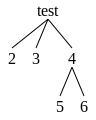

In [215]:
t1

In [217]:
#nltk.draw.tree.draw_trees([t1, t2])

In [221]:
list(t1)

['2', '3', Tree('4', ['5', '6'])]

In [147]:
help(t1)

Help on Tree in module nltk.tree.tree object:

class Tree(builtins.list)
 |  Tree(node, children=None)
 |  
 |  A Tree represents a hierarchical grouping of leaves and subtrees.
 |  For example, each constituent in a syntax tree is represented by a single Tree.
 |  
 |  A tree's children are encoded as a list of leaves and subtrees,
 |  where a leaf is a basic (non-tree) value; and a subtree is a
 |  nested Tree.
 |  
 |      >>> from nltk.tree import Tree
 |      >>> print(Tree(1, [2, Tree(3, [4]), 5]))
 |      (1 2 (3 4) 5)
 |      >>> vp = Tree('VP', [Tree('V', ['saw']),
 |      ...                  Tree('NP', ['him'])])
 |      >>> s = Tree('S', [Tree('NP', ['I']), vp])
 |      >>> print(s)
 |      (S (NP I) (VP (V saw) (NP him)))
 |      >>> print(s[1])
 |      (VP (V saw) (NP him))
 |      >>> print(s[1,1])
 |      (NP him)
 |      >>> t = Tree.fromstring("(S (NP I) (VP (V saw) (NP him)))")
 |      >>> s == t
 |      True
 |      >>> t[1][1].set_label('X')
 |      >>> t[1][1].lab

In [149]:
t1.pformat()

'(1 2 3 (4 5 6))'